Heart Disease in Cleveland
=====
**An analysis by Group 20 DSCI 100 007**

Phoebe McNair-Luxon, Alexandre Beauchemin, Kumaravendhan Ravichandran, Evi Dorsch

Data set source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [ ]:
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(readxl)
set.seed(4200)
install.packages("themis")
library(themis)

Part 1: Preliminary Data Analysis
=====
Cell 1: Summary of the data set

Cell 2: Visuization of the data set

In [72]:
# read in data 
Cl_heart_data <- read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", sep = ",",
                 col.names = c("age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
#convert from a dataframe to a tibble
Cl_heart_data <- as_tibble(Cl_heart_data)

# convert num from from dbl to factor
Cl_heart_data_2 <- Cl_heart_data |> 
    mutate(num=as_factor(num))

# collapse factor levels returning positive disease diagnosis
Cl_heart_data_2 <-  fct_collapse(Cl_heart_data_2$num,
    "No disease" = "0",
    "Disease" = c("1", "2", "3", "4")) |>
    bind_cols(Cl_heart_data_2)

# rename column
colnames(Cl_heart_data_2) <- c("disease_status", "age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# select for columns 
clean_heart_data <- Cl_heart_data_2 |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "disease_status")

# rename column
colnames(clean_heart_data) <- c("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")

# count number of observations for disease and no disease for use in next cell
count_before_scaling <- count(clean_heart_data, num)

# balance data
ups_recipe <- recipe(num ~ ., data = clean_heart_data) |>
  step_upsample(num, over_ratio = 1, skip = FALSE) |>
  prep()

clean_heart_data <- bake(ups_recipe, clean_heart_data)

# count number of observations for disease and no disease for use in next cell
count_after_scaling <- count(clean_heart_data, num)

#splitting data into training and testing sets
heart_data_split <-  initial_split(clean_heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_data_split)
heart_test <- testing(heart_data_split)
# head(heart_train)
# head(heart_test)

#create new data frame without num for calculating stats
heart_train_1 <- heart_train |>
    select(-num)

# visualizing the data (only training data)
names <- c("Mean", "Median")
mean_1 <- heart_train_1 |>
    map_df(mean, na.rm = TRUE)
median_1 <- heart_train_1 |>
    map_df(median, na.rm = TRUE)
tbl1 <- bind_rows(mean_1, median_1)
exploratory_analysis <- bind_cols(names, tbl1)
exploratory_analysis

number_of_rows <- heart_train |>  
    nrow()
number_of_rows

New names:
• `` -> `...1`
New names:
• `` -> `...1`


...1,age,sex,trestbps,chol,fbs,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mean,54.87805,0.6707317,133.2886,249.8333,0.1585366,1.054472
Median,55.50000,1.0000000,130.0000,245.0000,0.0000000,0.800000


[1] 246

In [76]:
#bind the two counts and label data with human readable names
count_data <- bind_cols(count_before_scaling, count_after_scaling) |>
    select(-num...3)

titles<- c("Disease Status", "Before Scaling", "After Scaling")
titles

colnames(count_data) <- titles

count_data

New names:
• `num` -> `num...1`
• `n` -> `n...2`
• `num` -> `num...3`
• `n` -> `n...4`


[1] "Disease Status" "Before Scaling" "After Scaling"

Disease Status,Before Scaling,After Scaling
<fct>,<int>,<int>
No disease,164,164
Disease,139,164


Part 2: Running the Analysis
=====
Analysis with just Census Data
----

In [ ]:
#Analysis with just Census Data
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)
#select relevant parameters
heart_train_census <- heart_train |>
    select("age", "sex", "num")
heart_test_census <- heart_test |>
    select("age", "sex", "num")

#make recipe with tune() function
heart_recipe_census <- recipe(num ~ ., data = heart_train_census) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_census <- vfold_cv(heart_train_census, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_census <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_census <- workflow() |>
       add_recipe(heart_recipe_census) |>
       add_model(heart_spec_tune_census)|>
       tune_grid(resamples = heart_vfold_census, grid = k_vals) 

accuracies_census <- heart_workflow_census |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_census <- ggplot(accuracies_census, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation")
accuracy_vs_k_census

#at this point we evaluate the accuracy of the model below to choose the best K

In [ ]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_census <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_census <- workflow() |>
    add_recipe(heart_recipe_census) |>
    add_model(heart_spec_census) |>
    fit(data = heart_train_census)

heart_predicted_census <- predict(heart_fit_census, heart_test_census) |>
    bind_cols(heart_test_census)

acc_census <- heart_predicted_census |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
tibble(acc_census)

confusion_census <- heart_predicted_census|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_census

false_positive_census <- 12/27

false_negative_census <- 15/27

tibble(acc_census, false_positive_census, false_negative_census)

Analysis with just Medical Data
-----

In [ ]:
#Analysis with just Medical Data
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)
#select relevant parameters
heart_train_med <- heart_train |>
    select("trestbps", "chol", "fbs", "oldpeak", "num")
heart_test_med <- heart_test |>
    select("trestbps", "chol", "fbs", "oldpeak", "num")

#make recipe with tune() function
heart_recipe_med <- recipe(num ~ ., data = heart_train_med) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_med <- vfold_cv(heart_train_med, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_med <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_med <- workflow() |>
       add_recipe(heart_recipe_med) |>
       add_model(heart_spec_tune_med)|>
       tune_grid(resamples = heart_vfold_med, grid = k_vals) 

accuracies_med <- heart_workflow_med |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_med <- ggplot(accuracies_med, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation")
accuracy_vs_k_med

#at this point we evaluate the accuracy of the model below to choose the best K

In [ ]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_med <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_med <- workflow() |>
    add_recipe(heart_recipe_med) |>
    add_model(heart_spec_med) |>
    fit(data = heart_train_med)

heart_predicted_med <- predict(heart_fit_med, heart_test_med) |>
    bind_cols(heart_test_med)

confusion_med <- heart_predicted_med|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_med

acc_med <- heart_predicted_med |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

false_positive_med <- 18/36

false_negative_med <- 18/36

tibble(acc_med, false_positive_med, false_negative_med)

Analysis with All Parameters
----

In [ ]:
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)

#select relevant parameters
heart_train_all <- heart_train |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")
heart_test_all <- heart_test |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")

#make recipe with tune() function
heart_recipe_all <- recipe(num ~ ., data = heart_train_all) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_all <- vfold_cv(heart_train_all, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_all <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_all <- workflow() |>
       add_recipe(heart_recipe_all) |>
       add_model(heart_spec_tune_all)|>
       tune_grid(resamples = heart_vfold_all, grid = k_vals) 

accuracies_all <- heart_workflow_all |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_all <- ggplot(accuracies_all, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation")
accuracy_vs_k_all

#at this point we evaluate the accuracy of the model below to choose the best K

In [ ]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_all <- workflow() |>
    add_recipe(heart_recipe_all) |>
    add_model(heart_spec_all) |>
    fit(data = heart_train_all)

heart_predicted_all <- predict(heart_fit_all, heart_test_all) |>
    bind_cols(heart_test_all)

acc_all <- heart_predicted_all |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

confusion_all <- heart_predicted_all|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_all

false_positive_all <- 9/24

false_negative_all <- 15/24

tibble(acc_all, false_positive_all, false_negative_all)

Visualizing the Models
---
Step 1: Combine all of the accuracy data into one dataframe

Step 2: Plot the accuracies of the different models as bar graphs

In [75]:
#bind all of the accuracies together 
accuracy_data <- bind_cols(acc_census,acc_med, acc_all) 
names <- c("Census_Accuracy","Medical_Accuracy", "All_Accuracy")
colnames(accuracy_data) <- names

#tidy the accuracy data (make in tidy format) 
tidy_accuracy_data <- pivot_longer(accuracy_data, 
            cols = Census_Accuracy:All_Accuracy, 
            names_to = "data_set", 
            values_to = "accuracy")
tidy_accuracy_data                     

New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`


data_set,accuracy
<chr>,<dbl>
Census_Accuracy,0.6951220
Medical_Accuracy,0.7317073
All_Accuracy,0.7682927


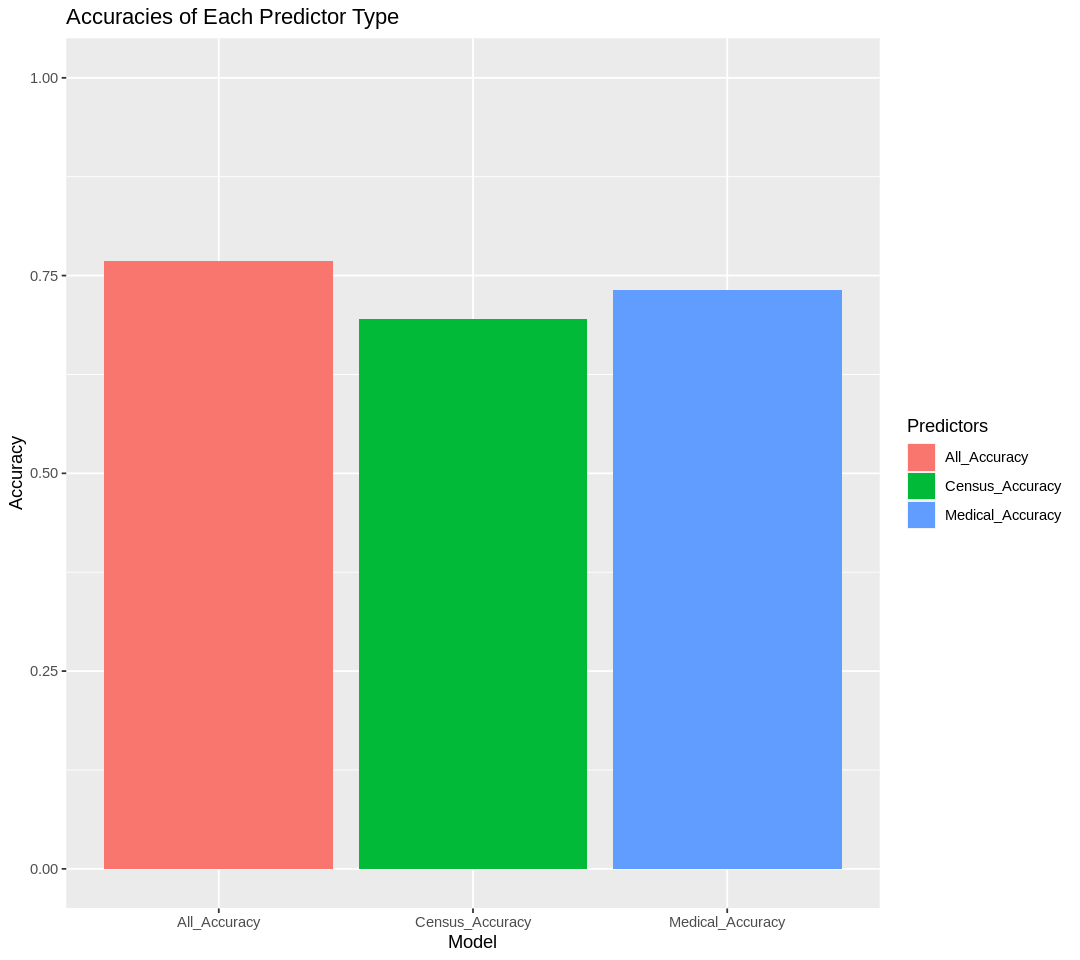

In [78]:
#plot the accuracies as a bar graph
Accuracy_plot <- tidy_accuracy_data |>
    ggplot(aes(x = data_set, y=accuracy, fill = data_set)) +
    geom_bar(stat = "identity") +
    labs(x= "Model", y="Accuracy", fill = "Predictors") +
    ylim(0:1) +
    ggtitle("Accuracies of Each Predictor Type")
Accuracy_plot

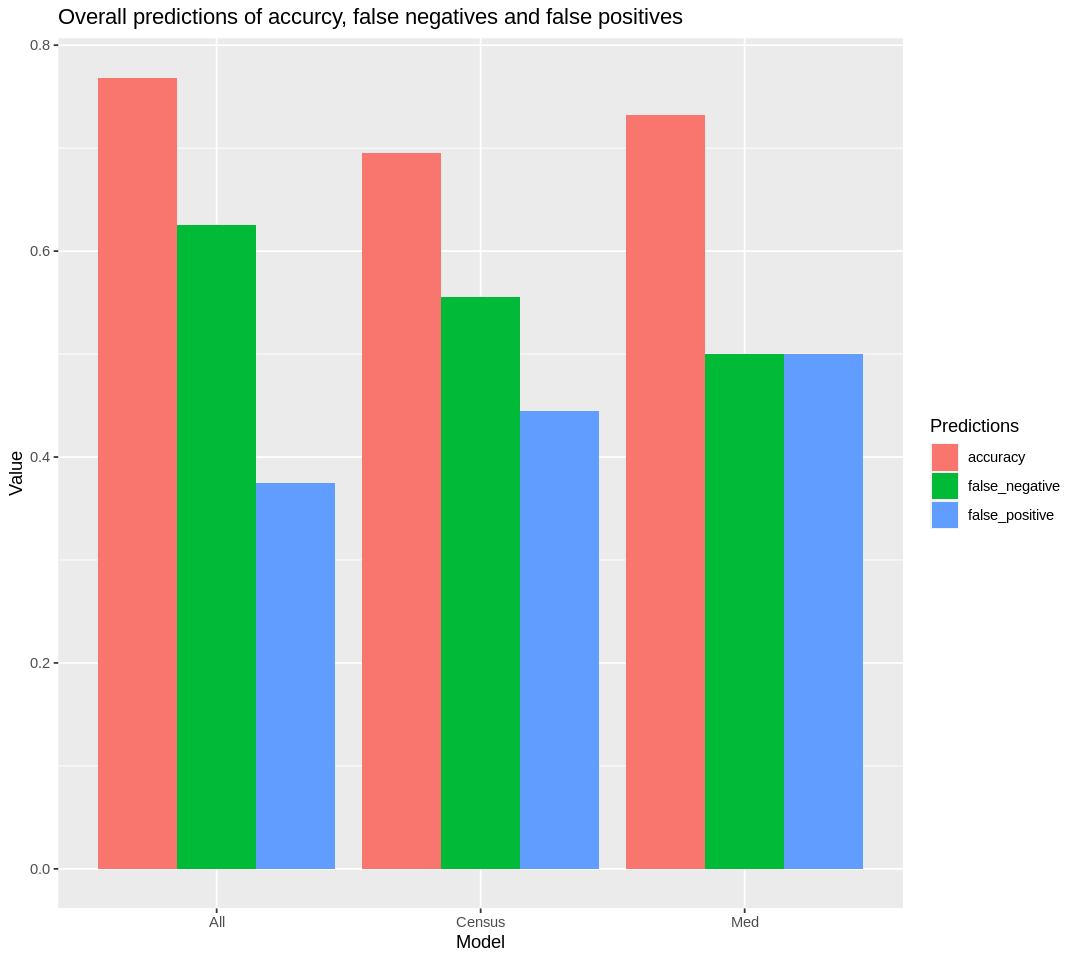

In [80]:
error_df <- data.frame(
  model = c("All", "Census", "Med"),
  accuracy = c(acc_all,acc_census, acc_med),
  false_positive = c(false_positive_all, false_positive_census, false_positive_med),
  false_negative = c(false_negative_all, false_negative_census, false_negative_med))

error_long <- tidyr::gather(df, key = "metric", value = "value", -model)

# Create the grouped bar chart
ggplot(error_long, aes(x = model, y = value, fill = metric)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "Value", fill = "Predictions")+
  ggtitle("Overall predictions of accurcy, false negatives and false positives")